In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG16 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'malimg-vgg16features.npy'
if os.path.exists(filename):
    print("Loading VGG16 extracted features from %s ..." %(filename))
    vgg16features = np.load(filename)
else:
    print("Extracting features from VGG16 layers ...")
    vgg16features = base_model.predict(X)
    print("Saving VGG16 extracted features into %s ..." %(filename))
    np.save(filename, vgg16features)

Loading VGG16 extracted features from malimg-vgg16features.npy ...


In [10]:
vgg16features.shape

(9339, 7, 7, 512)

In [11]:
vgg16features = np.reshape(vgg16features,(vgg16features.shape[0],-1))

In [12]:
vgg16features.shape

(9339, 25088)

In [13]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=-1)
top_model.fit(vgg16features,y)  # Training 

Fitting 5 folds for each of 169 candidates, totalling 845 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-09 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 148.0min


[CV] .............. C=0.01, gamma=1e-06, score=0.721092, total=89.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.718415, total=89.6min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.721092, total=90.7min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=99.1min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-09, score=0.315846, total=99.0min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.315846, total=99.7min
[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.401499, total=100.1min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 170.2min


[CV] ............. C=0.01, gamma=1e-07, score=0.401499, total=102.4min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-09, score=0.315846, total=102.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-09, score=0.315846, total=104.2min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=1e-08, score=0.315846, total=104.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-08, score=0.315846, total=105.3min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.401499, total=105.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=1e-07, score=0.401499, total=106.5min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 196.6min


[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............. C=0.01, gamma=1e-05, score=0.556745, total=130.2min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=286.1min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=286.7min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=291.2min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=297.6min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............ C=0.01, gamma=0.0001, score=0.401499, total=287.5min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=285.0min
[CV] C

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 531.2min


[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=290.7min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............. C=0.01, gamma=0.001, score=0.401499, total=293.7min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=293.8min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] .............. C=0.01, gamma=0.01, score=0.401499, total=289.8min
[CV] C=0.01, gamma=1000.0 ............................................
[CV] ............... C=0.01, gamma=0.1, score=0.401499, total=291.4min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=0.1, score=0.401499, total=292.4min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] ............... C=0.01, gamma=1.0, score=0.401499, total=282.8min
[CV] C=0.1, gamma=1e-09 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 714.7min


[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.315846, total=106.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.315846, total=103.6min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-09, score=0.315846, total=104.7min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-09, score=0.315846, total=99.9min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-08, score=0.401499, total=105.1min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .............. C=0.1, gamma=1e-08, score=0.401499, total=106.4min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.862955, total=71.3min
[CV] C

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 876.9min


[CV] .............. C=0.01, gamma=10.0, score=0.401499, total=292.3min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .............. C=0.01, gamma=10.0, score=0.401499, total=286.2min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=100.0, score=0.401499, total=285.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=100.0, score=0.401499, total=286.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=100.0, score=0.401499, total=290.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............ C=0.01, gamma=1000.0, score=0.401499, total=286.7min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............. C=0.01, gamma=100.0, score=0.401499, total=285.6min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 902.8min


[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.960385, total=33.5min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.960921, total=32.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.966274, total=34.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.958779, total=34.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.960385, total=34.2min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-05, score=0.744647, total=112.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=1e-05, score=0.746253, total=114.5min
[CV] C

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 1309.0min


[CV] ............. C=0.1, gamma=0.0001, score=0.471627, total=319.6min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .............. C=0.1, gamma=0.001, score=0.467345, total=318.3min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .............. C=0.1, gamma=0.001, score=0.465203, total=318.7min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] .............. C=0.1, gamma=0.001, score=0.464668, total=335.4min
[CV] C=0.1, gamma=100.0 ..............................................
[CV] ............... C=0.1, gamma=0.01, score=0.449143, total=325.2min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ............... C=0.1, gamma=0.01, score=0.450214, total=335.3min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] ............... C=0.1, gamma=0.01, score=0.444325, total=324.3min
[CV] C=0.1, gamma=1000.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 1461.0min


[CV] .............. C=1.0, gamma=1e-09, score=0.402034, total=107.5min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=1.0, gamma=1e-09, score=0.401499, total=104.7min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .............. C=1.0, gamma=1e-09, score=0.401499, total=110.1min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.875803, total=69.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.969486, total=23.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.875803, total=73.7min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.874732, total=73.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 1681.3min


[CV] ............... C=1.0, gamma=1e-06, score=0.988223, total=22.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=10.0, score=0.450214, total=329.7min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=10.0, score=0.444325, total=328.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=1.0, score=0.449143, total=338.4min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=100.0, score=0.449143, total=328.8min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............. C=0.1, gamma=1000.0, score=0.450214, total=327.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=10.0, score=0.450214, total=339.5min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 1788.9min


[CV] .............. C=1.0, gamma=1e-05, score=0.911135, total=111.5min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=1e-05, score=0.918094, total=106.2min
[CV] C=1.0, gamma=1.0 ................................................
[CV] .............. C=1.0, gamma=1e-05, score=0.915418, total=109.4min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............. C=1.0, gamma=0.0001, score=0.567452, total=314.3min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............. C=1.0, gamma=0.0001, score=0.576017, total=315.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............. C=1.0, gamma=0.0001, score=0.571199, total=329.8min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ............. C=1.0, gamma=0.0001, score=0.569593, total=329.3min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 2126.6min


[CV] ................ C=1.0, gamma=0.1, score=0.476445, total=331.1min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=0.1, score=0.476981, total=314.7min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=314.4min
[CV] C=10.0, gamma=1e-09 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=328.6min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=328.3min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] ................ C=1.0, gamma=1.0, score=0.473233, total=328.4min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.969486, total=22.3min
[CV] C=10.0, gamma=1e-08 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 2321.3min


[CV] .............. C=10.0, gamma=1e-06, score=0.990364, total=20.2min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.989829, total=21.6min
[CV] C=10.0, gamma=1e-05 .............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.991970, total=22.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.990364, total=22.4min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.990899, total=21.7min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ................ C=1.0, gamma=1.0, score=0.476445, total=314.3min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] ............. C=10.0, gamma=1e-05, score=0.919165, total=106.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 2525.2min


[CV] ............. C=1.0, gamma=1000.0, score=0.475375, total=338.4min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.473233, total=337.9min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............. C=1.0, gamma=1000.0, score=0.476445, total=337.5min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.576552, total=342.0min
[CV] C=10.0, gamma=1.0 ...............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.579764, total=341.7min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.574411, total=340.7min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ............ C=10.0, gamma=0.0001, score=0.582976, total=319.8min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 2931.0min


[CV] ............... C=10.0, gamma=1.0, score=0.476445, total=344.2min
[CV] C=100.0, gamma=1e-09 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.969486, total=22.4min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.476445, total=344.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.476981, total=343.4min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.972163, total=22.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.473233, total=343.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ............. C=100.0, gamma=1e-09, score=0.974839, total=22.0min
[CV] C=100.0, gamma=1e-07 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 3154.1min


[CV] ............ C=100.0, gamma=1e-05, score=0.919165, total=111.8min
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............ C=100.0, gamma=1e-05, score=0.915953, total=111.6min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............... C=10.0, gamma=1.0, score=0.476981, total=343.4min
[CV] C=100.0, gamma=0.001 ............................................
[CV] .............. C=10.0, gamma=10.0, score=0.476445, total=344.1min
[CV] C=100.0, gamma=0.001 ............................................
[CV] .............. C=10.0, gamma=10.0, score=0.476445, total=343.0min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=1e-05, score=0.918094, total=110.9min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............ C=100.0, gamma=1e-05, score=0.921842, total=113.1min
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 3569.1min


[CV] ............ C=100.0, gamma=0.001, score=0.504283, total=345.9min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.001, score=0.502141, total=347.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.502141, total=345.7min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.503747, total=347.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............ C=100.0, gamma=0.001, score=0.503747, total=347.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=0.01, score=0.480728, total=347.5min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............. C=100.0, gamma=0.01, score=0.482334, total=327.2min
[CV] C=100.0, gamma=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 3710.2min


[CV] ............ C=1000.0, gamma=1e-08, score=0.989829, total=12.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.989829, total=12.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=1.0, score=0.473233, total=346.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.989293, total=13.7min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.990899, total=12.7min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.989829, total=12.5min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.990364, total=12.7min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 3989.4min


[CV] ........... C=100.0, gamma=1000.0, score=0.475375, total=322.2min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............ C=100.0, gamma=100.0, score=0.473233, total=341.4min
[CV] C=1000.0, gamma=0.1 .............................................
[CV] ............ C=100.0, gamma=100.0, score=0.476445, total=341.2min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=100.0, gamma=1000.0, score=0.476445, total=321.6min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=100.0, gamma=1000.0, score=0.473233, total=320.6min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] ........... C=100.0, gamma=1000.0, score=0.476445, total=321.4min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .......... C=1000.0, gamma=0.0001, score=0.576552, total=316.4min
[CV] C=1000.0, gamma=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 4411.1min


[CV] ............. C=1000.0, gamma=1.0, score=0.476445, total=344.8min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.989293, total=11.7min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.988758, total=12.0min
[CV] C=10000.0, gamma=1e-08 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.990899, total=12.0min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.990364, total=12.0min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-09, score=0.989829, total=11.6min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] ........... C=10000.0, gamma=1e-08, score=0.989293, total=12.0min
[CV] C=10000.0, gamma=1e-07 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 4625.5min


[CV] ............ C=1000.0, gamma=10.0, score=0.476445, total=320.9min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ............ C=1000.0, gamma=10.0, score=0.473233, total=317.2min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ............ C=1000.0, gamma=10.0, score=0.476445, total=316.5min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=1000.0, gamma=100.0, score=0.476445, total=317.9min
[CV] C=10000.0, gamma=0.01 ...........................................
[CV] ........... C=1000.0, gamma=100.0, score=0.476445, total=313.6min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=1000.0, gamma=100.0, score=0.475910, total=314.1min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] ........... C=1000.0, gamma=100.0, score=0.473233, total=318.8min
[CV] C=10000.0, gamma=0.1 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 5051.1min


[CV] ............ C=10000.0, gamma=0.1, score=0.476981, total=320.7min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.989293, total=11.9min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.988758, total=11.8min
[CV] C=100000.0, gamma=1e-09 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.990899, total=12.1min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.990364, total=11.9min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .......... C=100000.0, gamma=1e-09, score=0.989829, total=11.6min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] ............ C=10000.0, gamma=0.1, score=0.476981, total=292.9min
[CV] C=100000.0, gamma=1e-08 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 5288.3min


[CV] ......... C=100000.0, gamma=1e-05, score=0.919165, total=100.0min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] ......... C=100000.0, gamma=1e-05, score=0.915953, total=102.9min
[CV] C=100000.0, gamma=0.001 .........................................
[CV] .......... C=100000.0, gamma=1e-05, score=0.918094, total=96.8min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ......... C=100000.0, gamma=1e-05, score=0.921842, total=106.8min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ........... C=10000.0, gamma=10.0, score=0.473233, total=312.7min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .......... C=10000.0, gamma=100.0, score=0.476445, total=299.0min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] ........... C=10000.0, gamma=10.0, score=0.476445, total=314.1min
[CV] C=100000.0, gamma=0.01 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 5714.7min


[CV] ........... C=100000.0, gamma=1.0, score=0.476445, total=291.3min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.476981, total=303.1min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=1.0, score=0.476445, total=291.9min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.473233, total=302.7min
[CV] C=1000000.0, gamma=1e-09 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.989293, total=10.8min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ........... C=100000.0, gamma=0.1, score=0.476981, total=312.1min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] ......... C=1000000.0, gamma=1e-09, score=0.988758, total=11.3min
[CV] C=1000000.0, gamma=1e-08 ........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 5937.6min


[CV] ......... C=1000000.0, gamma=1e-05, score=0.921842, total=99.8min
[CV] C=1000000.0, gamma=0.001 ........................................
[CV] .......... C=100000.0, gamma=10.0, score=0.476445, total=317.3min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] .......... C=100000.0, gamma=10.0, score=0.476445, total=316.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] .......... C=100000.0, gamma=10.0, score=0.473233, total=292.5min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=100000.0, gamma=100.0, score=0.475910, total=299.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] .......... C=100000.0, gamma=10.0, score=0.476445, total=315.6min
[CV] C=1000000.0, gamma=0.01 .........................................
[CV] ......... C=100000.0, gamma=100.0, score=0.476445, total=298.3min
[CV] C=1000000.0, gamma=0.1 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 565 tasks      | elapsed: 6418.1min


[CV] ........ C=10000000.0, gamma=1e-09, score=0.989293, total=12.1min
[CV] C=10000000.0, gamma=1e-09 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.988758, total=11.7min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.990899, total=12.4min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.990364, total=11.6min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] .......... C=1000000.0, gamma=1.0, score=0.476445, total=323.8min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-09, score=0.989829, total=11.8min
[CV] C=10000000.0, gamma=1e-08 .......................................
[CV] ........ C=10000000.0, gamma=1e-08, score=0.989293, total=11.7min
[CV] C=10000000.0, gamma=1e-07 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed: 6678.1min


[CV] ........ C=1000000.0, gamma=100.0, score=0.476445, total=305.1min
[CV] C=10000000.0, gamma=0.01 ........................................
[CV] ........ C=1000000.0, gamma=100.0, score=0.475910, total=306.6min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=1000000.0, gamma=100.0, score=0.476445, total=305.6min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=1000000.0, gamma=100.0, score=0.476445, total=323.3min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ........ C=1000000.0, gamma=100.0, score=0.473233, total=323.6min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=1000000.0, gamma=1000.0, score=0.475910, total=323.2min
[CV] C=10000000.0, gamma=0.1 .........................................
[CV] ....... C=1000000.0, gamma=1000.0, score=0.475375, total=323.6min
[CV] C=10000000.0, gamma=1.0 .........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 637 tasks      | elapsed: 7141.4min


[CV] ....... C=100000000.0, gamma=1e-09, score=0.989829, total=11.3min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.988758, total=11.7min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.989293, total=12.2min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.990899, total=12.4min
[CV] C=100000000.0, gamma=1e-07 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.990364, total=12.1min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-08, score=0.989829, total=12.0min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] ....... C=100000000.0, gamma=1e-07, score=0.989829, total=12.2min
[CV] C=100000000.0, gamma=1e-06 ......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 7448.6min


[CV] ...... C=10000000.0, gamma=1000.0, score=0.476445, total=323.9min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.576552, total=305.1min
[CV] C=100000000.0, gamma=1.0 ........................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.579764, total=306.3min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.574411, total=306.1min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.582976, total=305.9min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ..... C=100000000.0, gamma=0.0001, score=0.579229, total=306.7min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] ...... C=100000000.0, gamma=0.001, score=0.504283, total=308.1min
[CV] C=100000000.0, gamma=10.0 .......................................
[CV] .

[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed: 7876.3min


[CV] ...... C=1000000000.0, gamma=1e-07, score=0.989829, total=12.1min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.990364, total=19.2min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.989829, total=19.6min
[CV] C=1000000000.0, gamma=1e-05 .....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.991970, total=20.8min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.990364, total=21.0min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ...... C=1000000000.0, gamma=1e-06, score=0.990899, total=20.7min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] ........ C=100000000.0, gamma=1.0, score=0.476981, total=309.0min
[CV] C=1000000000.0, gamma=0.0001 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 8403.4min


[CV] ..... C=1000000000.0, gamma=0.001, score=0.503747, total=325.0min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=1000000000.0, gamma=0.01, score=0.475375, total=309.0min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ...... C=1000000000.0, gamma=0.01, score=0.479657, total=326.9min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.476445, total=326.4min
[CV] C=1000000000.0, gamma=1000.0 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.476981, total=310.6min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.476445, total=327.0min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] ....... C=1000000000.0, gamma=0.1, score=0.476981, total=326.8min
[CV] C=10000000000.0, gamma=1e-09 ....................................
[CV] .

[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 8736.0min


[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=1e-05, score=0.921842, total=102.3min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] .... C=10000000000.0, gamma=1e-05, score=0.918094, total=105.7min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=1000000000.0, gamma=100.0, score=0.476445, total=333.9min
[CV] C=10000000000.0, gamma=0.01 .....................................
[CV] ..... C=1000000000.0, gamma=100.0, score=0.475910, total=335.0min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] .... C=1000000000.0, gamma=1000.0, score=0.475375, total=322.8min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=1000000000.0, gamma=100.0, score=0.476445, total=334.3min
[CV] C=10000000000.0, gamma=0.1 ......................................
[CV] ..... C=1000000000.0, gamma=100.0, score=0.473233, total=335.2min
[CV] C

[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed: 9420.7min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 100.0, 'gamma': 1e-08} - score: 0.9908


In [15]:
top_model.cv_results_

{'mean_fit_time': array([  5031.58852043,   5086.8760438 ,   5160.65694561,   4512.02089396,
          6905.846386  ,  16294.31838946,  16381.1925756 ,  16291.31527882,
         16531.51907659,  16191.13694   ,  16266.2203588 ,  16199.77596822,
         16268.78456535,   5156.92631383,   5146.69461384,   3534.2943532 ,
          1566.55370698,   6187.39421802,  17702.39934959,  18087.80629034,
         18178.763621  ,  19108.77240939,  19846.50742373,  18995.41107841,
         19132.64148741,  18578.48522406,   5339.04182239,   3526.65009084,
           982.03895483,    983.12599635,   6027.90460615,  18220.49885721,
         18303.51099114,  18493.23854098,  18438.37301016,  18323.98692384,
         18337.42768621,  18157.21195436,  18957.03284698,   3493.24439116,
           931.31866241,    552.44741011,    994.60215001,   6109.31353559,
         18941.97611465,  18814.82369323,  18661.61705256,  19055.59859519,
         19551.83613729,  18759.68353033,  18504.71992006,  18527.45248

In [16]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0000000000000001e-09},
 mean: 0.31585, std: 0.00000, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.72034, std: 0.00105, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.55493, std: 0.00276, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 100.0},
 mean: 0.40150, std: 0.00000, params: {'C': 0.01, 'gamma': 1000.0},
 mean: 0.31585, std: 0.00000, params: {'C': 0.100

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    
    ax.set_xscale('log')
    #ax.set_ylim([0.0,1.0])

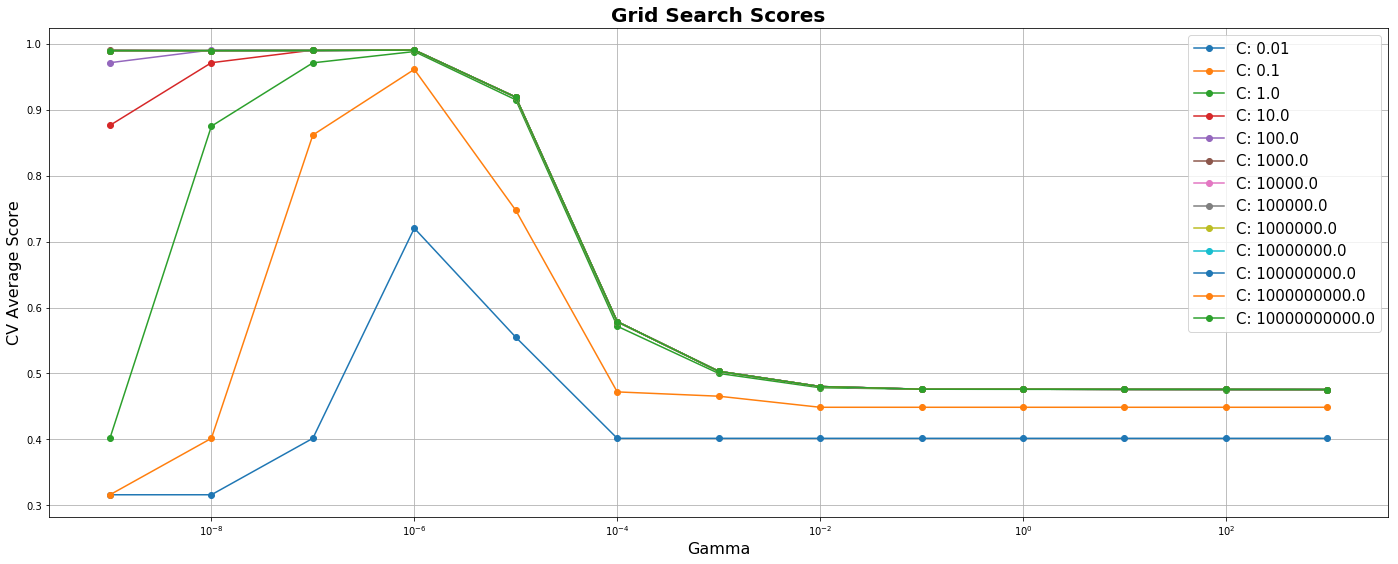

In [18]:
plot_grid_search(top_model.cv_results_,gamma_range,C_range,'Gamma','C')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


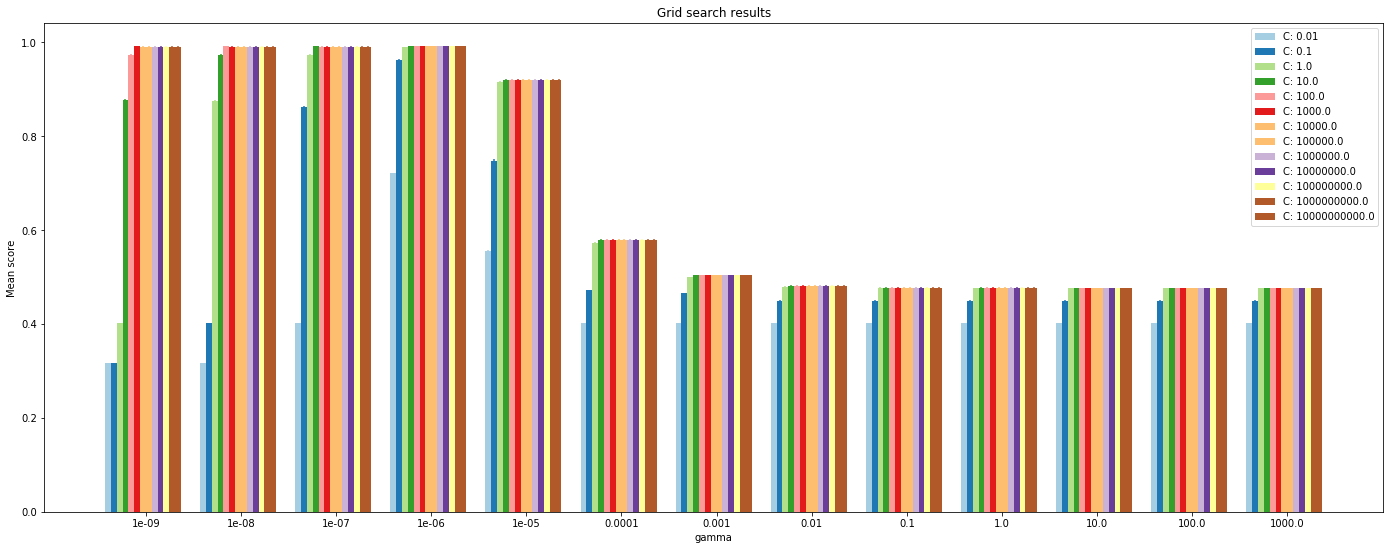

In [19]:
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


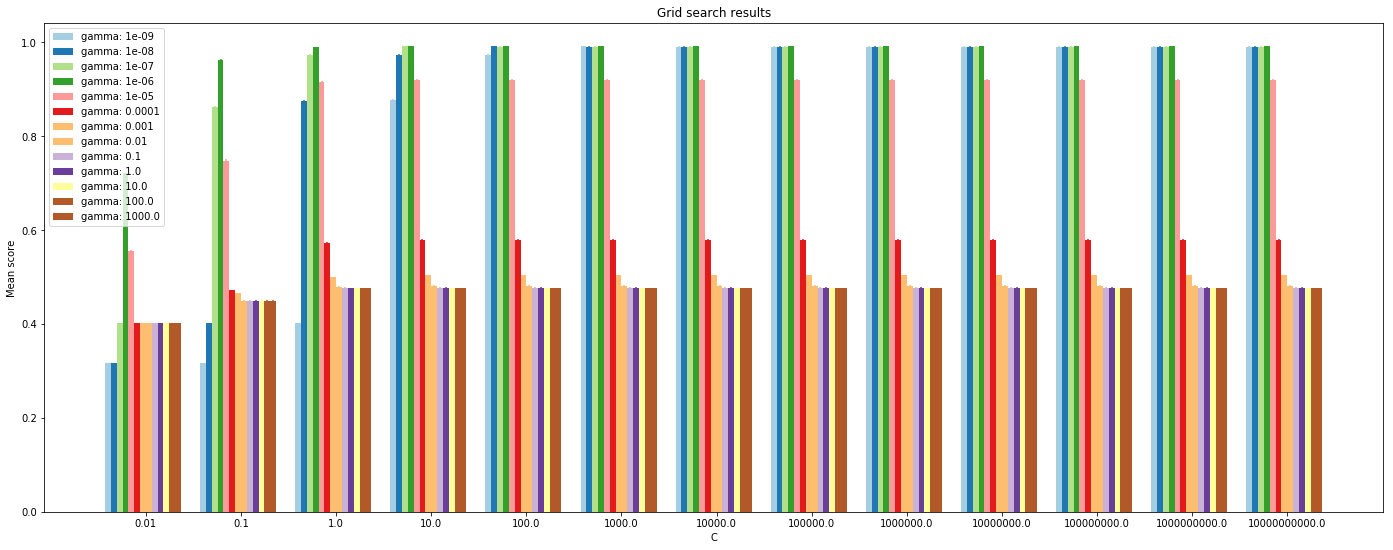

In [20]:
skplot.grid_search(top_model.grid_scores_, change='C', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()

In [21]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.SVC(C=100.0,gamma=1e-08)
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, vgg16features, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

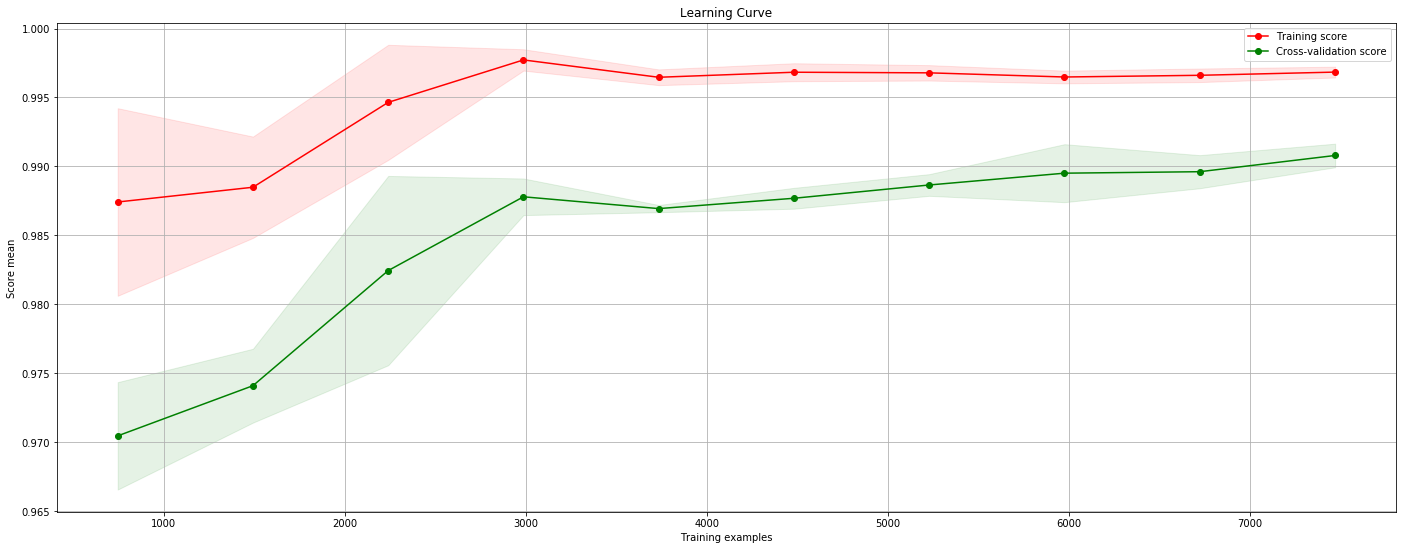

In [22]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()